In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Household Power Consumption
Additional explanations
- https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
- https://machinelearningmastery.com/how-to-load-and-explore-household-electricity-usage-data/

Our Target: 'global_active_power' household global minute-averaged active power (in kilowatt). This represents the power consumed at current time.

In [57]:
df = pd.read_csv("data/household_power_consumption.txt", 
                 sep=";", 
                 low_memory=False, 
                 infer_datetime_format=True, 
                 parse_dates={'date':[0]}, 
                 )

In [58]:
df.head(3)

,date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    object        
 3   Global_reactive_power  object        
 4   Voltage                object        
 5   Global_intensity       object        
 6   Sub_metering_1         object        
 7   Sub_metering_2         object        
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 142.5+ MB


In [60]:
len(df)

2075259

In [61]:
# Duplicates?
len(df) - len(df.drop_duplicates())

0

In [63]:
# Missing values?
df.replace('?', np.nan, inplace=True)
df.isna().sum()

date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

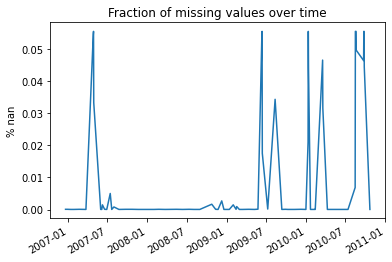

In [64]:
df[df.Global_active_power.isna()].date.value_counts(normalize=True).plot()
plt.title("Fraction of missing values over time")
plt.ylabel("% nan")
plt.show()

From summer 2009 on data contains more days with missing values. How many days are missing completely (in other words, have no data at all)?

In [74]:
sum(df[df.Global_active_power.isna()].date.value_counts() == df.date.value_counts().max())

9

How many days do we have?

In [75]:
len(df.date.unique())

1442

Since we want to predict consumption per day (not per minute), we'll replace missing data for Global_active_power with the mean after grouping by day. Specifically we'll backward fill them.

In [96]:
df.Global_active_power = df.Global_active_power.astype(float)
y = df[["date", "Global_active_power"]].groupby("date").mean()
y.Global_active_power.bfill(inplace=True)

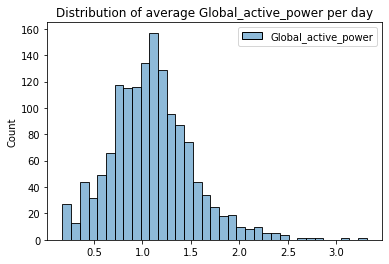

In [99]:
sns.histplot(y).set(title="Distribution of average Global_active_power per day");plt.show()

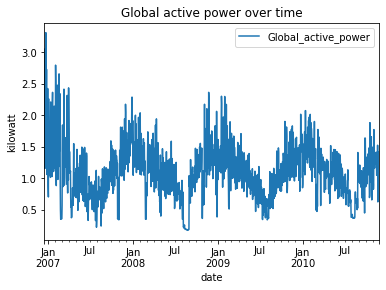

In [101]:
y.plot();plt.title("Global active power over time"); plt.ylabel("kilowatt"); plt.show()

On the first glance we see already some nice seasonal patterns.